<a href="https://colab.research.google.com/github/team-sesac/transformer-for-finance/blob/main/src/ch6_RNN_LSTM/Bidirectional_LSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bidirectional LSTM  을 사용
https://icedhotchoco.tistory.com/entry/DAY-80


In [1]:
!pip install -q finance-datareader
import FinanceDataReader as fdr
import pandas as pd


In [2]:
df = fdr.DataReader('122870', '2010') #YG엔터테인먼트
df.shape

(2973, 6)

In [3]:
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2011-11-23,25446,29263,25446,29263,147372,NaN
2011-11-24,30498,33641,30498,33641,1575530,0.149609
2011-11-25,34426,36372,28926,29787,1429458,-0.114563
2011-11-28,30498,30984,28739,29376,543186,-0.013798
2011-11-29,29898,30647,28813,29376,396516,0.000000


In [4]:
df_ohlcv = df.iloc[:,:-1]
dfx = df_ohlcv.drop(columns='Close')
dfy = df_ohlcv['Close']
dfx.shape, dfy.shape

((2973, 4), (2973,))

In [5]:
from sklearn.preprocessing import MinMaxScaler

mmsx = MinMaxScaler()
mmsy = MinMaxScaler()
x_mms = mmsx.fit_transform(dfx)
y_mms = mmsy.fit_transform(dfy.to_frame())
#예측 후 스케일링 값을 복원할 때 편하게 하기 위해서, x, y 따로 스케일링 진행

pd.DataFrame(x_mms).describe()

,0,1,2,3
count,2973.000000,2973.000000,2973.000000,2973.000000
mean,0.315119,0.313019,0.315133,0.045790
std,0.167114,0.167646,0.163810,0.057076
min,0.000000,0.000000,0.000000,0.000000
25%,0.174867,0.172302,0.177300,0.015137
50%,0.311170,0.308192,0.312438,0.031516
75%,0.406915,0.404421,0.405641,0.057506
max,1.000000,1.000000,1.000000,1.000000


In [6]:
x_mms[0:10], y_mms[10]

(array([[0.07773936, 0.11915475, 0.08725319, 0.0210353 ],
        [0.14492021, 0.17608583, 0.15511081, 0.26657461],
        [0.19715426, 0.21159948, 0.13399597, 0.24146085],
        [0.14492021, 0.14153446, 0.13148422, 0.08908652],
        [0.13694149, 0.13715215, 0.13247817, 0.06386995],
        [0.13545213, 0.13764629, 0.10584285, 0.09703988],
        [0.11305851, 0.1123407 , 0.10584285, 0.09741984],
        [0.11953457, 0.11087126, 0.11339154, 0.02934558],
        [0.10409574, 0.09821847, 0.09830759, 0.02689974],
        [0.08917553, 0.11816645, 0.09327065, 0.10163996]]),
 array([0.09446865]))

In [7]:
window_size = 10
x_data = []
y_data = []
for start in range(len(y_mms)-window_size):
  stop = start + window_size
  x_data.append(x_mms[start:stop])
  y_data.append(y_mms[stop])

In [8]:
print(len(y_mms))
print(len(y_data))

2973
2963


Train, Test 분할 (80:20 = 2745 : 687)

In [9]:
import numpy as np
split_size = int(len(x_data)*0.8)
X_train = np.array(x_data[:split_size])
# X_test = np.array(x_data[split_size:])
X_test = np.array(x_data)
y_train = np.array(y_data[:split_size])
# y_test = np.array(y_data[split_size:])
y_test = np.array(y_data)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2370, 10, 4), (2963, 10, 4), (2370, 1), (2963, 1))

In [10]:
import torch
import torch.nn as nn

class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1, dropout_rate=0.5):
        super(BidirectionalLSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size, hidden_size1, bidirectional=True, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(hidden_size1 * 2, hidden_size2, bidirectional=True, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size2 * 2, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Assuming X_train[0].shape is (sequence_length, input_features)
input_size = X_train[0].shape[1]
hidden_size1 = 64
hidden_size2 = 32

model = BidirectionalLSTMModel(input_size, hidden_size1, hidden_size2)
print(model)


BidirectionalLSTMModel(
  (lstm1): LSTM(4, 64, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


<Axes: >

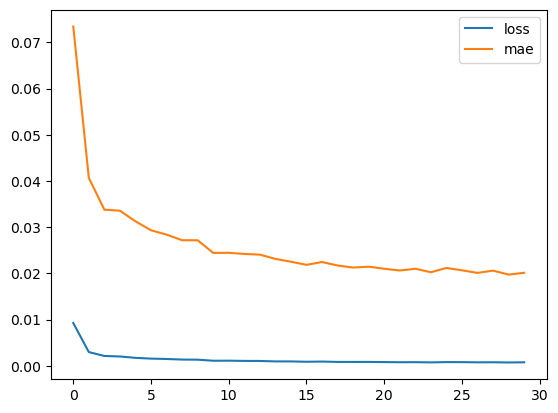

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd

# Assuming X_train and y_train are NumPy arrays or PyTorch tensors

# Convert NumPy arrays to PyTorch tensors if needed
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Assuming model is an instance of BidirectionalLSTMModel

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Move the model and data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

# Training loop
epochs = 30
batch_size = 32

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

history = {'loss': [], 'mae': []}

for epoch in range(epochs):
    total_loss = 0.0
    total_mae = 0.0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        mae = torch.mean(torch.abs(outputs - targets))

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(inputs)
        total_mae += mae.item() * len(inputs)

    average_loss = total_loss / len(X_train)
    average_mae = total_mae / len(X_train)

    history['loss'].append(average_loss)
    history['mae'].append(average_mae)

# Convert history to a DataFrame and plot
df_history = pd.DataFrame(history)
df_history[['loss', 'mae']].plot()


In [12]:
# Assuming X_test is a NumPy array or PyTorch tensor

# Convert NumPy array to PyTorch tensor if needed
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Move the model and data to GPU if available
X_test_tensor = X_test_tensor.to(device)
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Move predictions back to CPU if needed
y_pred = y_pred_tensor.cpu().numpy()

# Convert predictions and ground truth to a DataFrame
df_test = pd.DataFrame(y_test, columns=['test'])
df_test['predict'] = y_pred


y_test_date = df.iloc[-y_test.shape[0]:].index

# Convert predictions and ground truth to a DataFrame
df_test = pd.DataFrame(y_test, columns=['test'])
df_test['predict'] = y_pred
# df_test.shape
# print(y_test.shape[0])

df_test.index = y_test_date

In [13]:
df_test

,test,predict
Date,,
2011-12-07,0.094469,0.109835
2011-12-08,0.092488,0.108514
2011-12-09,0.102376,0.105616
2011-12-12,0.122139,0.104248
2011-12-13,0.126587,0.112628
...,...,...
2023-12-11,0.490429,0.499589
2023-12-12,0.449505,0.498527
2023-12-13,0.433663,0.473448


In [14]:
#스케일링된 값을 원래값으로 복원
y_predict_inverse = mmsy.inverse_transform(y_pred)
# y_test_origin = df.iloc[-len(y_pred):, [-3]]
y_test_origin = df.iloc[:, [-3]] # 발표 자료용
df_test['Actual'] = y_test_origin
df_test['Predict'] = y_predict_inverse
df_test

,test,predict,Actual,Predict
Date,,,,
2011-12-07,0.094469,0.109835,26606,27770.019531
2011-12-08,0.092488,0.108514,26456,27669.919922
2011-12-09,0.102376,0.105616,27205,27450.390625
2011-12-12,0.122139,0.104248,28702,27346.796875
2011-12-13,0.126587,0.112628,29039,27981.533203
...,...,...,...,...
2023-12-11,0.490429,0.499589,56600,57293.875000
2023-12-12,0.449505,0.498527,53500,57213.449219
2023-12-13,0.433663,0.473448,52300,55313.664062


<Axes: xlabel='Date'>

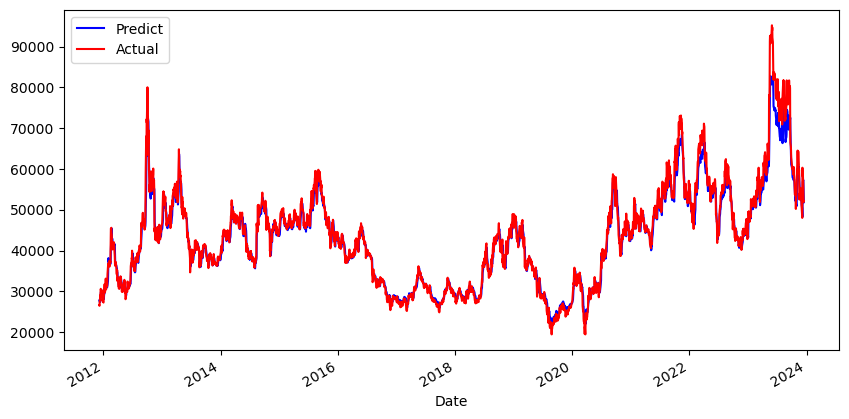

In [16]:
df_test[['Predict', 'Actual']].plot(figsize=(10, 5), cmap='bwr')